In [52]:
#Import dependencies
import numpy as np
import math
import random
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.special import erfc

### Required Functions ###

In [53]:
### Generating Random Binary Signal

def binary(N,sym_len):
    rand_n = np.random.rand(N) #generate N random numbers between 0 and 1
    rand_n[np.where(rand_n >= 0.5)] = 1
    rand_n[np.where(rand_n <= 0.5)] = 0
    plt.stem(rand_n)
    #generate signal
    sig = np.zeros(N*sym_len) #N*sym_len = total duration of 16 symbols or total number of samples in these 16 symbols

    id_n = np.where(rand_n == 1) #storing index numbers of rand_n where rand_n = 1

    for i in id_n[0]:  #id_n results in a numpy array in the form of a tuple, so we consider index = 0
        temp = int(i*sym_len)
        sig[temp:temp+sym_len] = 1 #making the signal from temp to temp+sym_len as
        # 1 i.e., say symbol length = 3, and binary bits are 1 0 1 1 then signal
        # will be 111 000 111 111
    return sig

C:\Users\Zunayeed\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Shape of ASK:  (160000,)


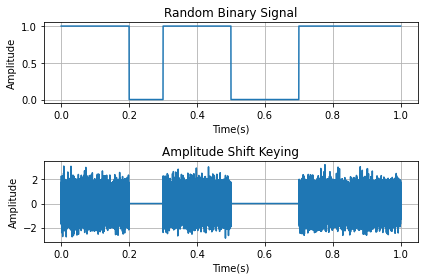

In [54]:
##### ASK Modulation (OOK)

def ask_mod():
    #carrier information
    L = 16
    Fc = 10000 #900e6 #carrier frequency
    Fs = L*Fc #sampling frequency
    T = 1 #simulation time
    t = np.arange(0,T,T/Fs)
    #Generate random binary signal
    #import generate_random_binary_signal as ran_bin
    Tb = 0.1 #bit duration
    sym_len = int(Tb*Fs)                   #number of samples to represent 1 symbol or symbol duration
    N = int(np.floor(np.size(t)/sym_len))  #number of symbols = total time length/number of samples

    sig =  binary(N,sym_len)

    #plot
    plt.subplot(2,1,1)
    plt.plot(t,sig);plt.xlabel('Time(s)');plt.ylabel('Amplitude')
    plt.title('Random Binary Signal')
    plt.grid()

    x = (np.random.randn(N*sym_len) + 1j*np.random.randn(N*sym_len))/np.sqrt(2); #np.sin(2*pi*Fc*t); ### CARRIER SIGNAL
    #plot ASK
    ask = x*sig;

    plt.subplot(2,1,2)
    plt.plot(t,ask);plt.xlabel('Time(s)');plt.ylabel('Amplitude')
    plt.title('Amplitude Shift Keying')
    plt.grid()
    plt.tight_layout()

    return ask,t

#Modulation
(ask,t) = ask_mod()
print('Shape of ASK: ',np.shape(ask))

In [55]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
print(abs(ask))

[0.17560267 0.40565376 0.26403074 ... 0.2970462  0.3573875  0.66266418]


In [56]:
#Pathloss Model - Log distance
def logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n):
    #Pt_dBm = Transmitted power in dBm
    #G_BD_dBi = Gain of the BD antenna in dBi
    #G_AP_dBi = Gain of the AP antenna in dBi
    #f = frequency of transmitted signal in Hertz
    #d0 = reference distance of receiver from the transmitter in meters
    #d = array of distances at which the loss needs to be calculated
    #L = Other System Losses, for no Loss case L=1
    #sigma = Standard deviation of log Normal distribution (in dB)
    #n = path loss exponent
    #Pr_dBm = Received power in dBm
    #PL = path loss due to log normal shadowing
    lamda_ = (3*10**8)/f #Wavelength in meters
    K = 20*math.log10((4*np.pi*d0)/lamda_) # Path Loss factor *******- 10*n*math.log10(d0) - 10*math.log10(L) #path-loss factor
    X = sigma*np.random.randn() #normal random variable
    PL_dB = Gt_dBi + Gr_dBi + K + 10*n*math.log10(d/d0) + X  #PL(d) including antennas gains

    #Pr_dBm = Pt_dBm + PL #Receieved power in dBm at d meters
    return PL_dB


#AP-BD Channel Gain
def APBD_ChannelGain(f):
    Pt_dBm = 30 #1W AP transmission power 1W = 30dBm
    Gt_dBi = 1 #Gain of the AP antenna in dBi
    Gr_dBi = 1 #Gain of the BD antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 3 #distance between AP and BD #Throughput reduces significantly after 4 meters ()
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#J-AP Channel Gain
def JAP_ChannelGain(f):
    M = 5
    P_J = 10 #np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 2 #distance between J and AP
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#J-BD Channel Gain
def JBD_ChannelGain(f):
    M = 5
    P_J = 10 #np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 2 #distance between J and AP
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    G_dB = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    G = 10**(G_dB/10)
    return G

#Loopback Channel Gain (SIC)
def loopback_Channel():
    epsilon = 1e-10 #very small number
    Pt_dBm = 30 #should be same as AP transmission power
    #g_hat: feedback channel coefficient
    #g_bar = 7e-5 #g_bar: feedback channel coefficient estimation
    #g_tilde = 6e-5#g_tilde: estimation error
    #g_hat = g_bar + (sqrt(epsilon))*g_tilde
    G = 1 #E[g_tilde**2]=1
    sigma = np.random.normal(loc=0.0, scale=1.0, size=None)
    phi = -20 #dBm 30dBm reduction = 60dB reduction, by current techniques, it has been reported that SI can be canceled up to −81 dB in analog domain
    combined_power_dB = (Pt_dBm+phi) + sigma**2
    combined_power = 10**(combined_power_dB/10)
    P = combined_power*epsilon*G
    return P

### System Parameters ###

In [57]:
#System parameters
N=10000 # Number of symbols to transmit
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period) Tb (bit period) = symbol duration = (1/900MHz) = 1.1ns
deltaf = 10e6 #frequency step
Fc = 900e6 #900MHz #base carrier frequency
Fs=L*Fc # sampling frequency
#Backscatter Reflection Coefficient - when the tag wants to transmits a 1, it reflects and absorbs when it wants to transmit a 0
# mu = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
# (s_bb,t)= bpsk_mod(mu,L) # BPSK modulation(waveform) - baseband

### Noise ###

In [58]:
#random.normal(loc=0.0, scale=1.0, size=None); loc => mean, scale => Standard deviation of the distribution (must be non-negative
def complex_noise(mean, variance, size):
    # Generate real and imaginary parts separately with normal distribution
    real_part = np.random.normal(mean, np.sqrt(variance), size)
    imag_part = np.random.normal(mean, np.sqrt(variance), size)
    # Combine real and imaginary parts into complex numbers
    complex_noise = real_part + 1j * imag_part
    return complex_noise

In [59]:
### Difference Noise Floor for each channel
target_SNR = []
def desired_SNR(k):
    target_SNR = [5,10,15,20,25,30,35,40,45,50]
    return target_SNR[k]

# k = 0
# SNR = desired_SNR(k)
# print(SNR)

### Jammer Strategy ###

In [60]:
def Jammer_RR(n,K_ch):
#     M = 5 #Jammer power level upper limit
    P_J = 10 # np.random.randint(low=0,high=M,dtype = int) #choose a power level between 0 to 4 W and
    #P_J = 10*math.log10(P_J_Watt) + 30  #convert P_J to dBm
    deltaf = 10e6 #frequency step
    Fc = 900e6 #900MHz #base carrier frequency
    seq = np.arange(0,K_ch,dtype=int)
    n = n+1
    if n == len(seq):
        n = 0
    k_J = seq[n]
    f_J = Fc + (k_J*deltaf)  #Jammer follows round robin
    return (P_J,f_J,n)

# Jammer Signal
x_J = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)

In [61]:
def Jammer_Random(K_ch):
#     M = 5 #Jammer power level upper limit
    P_J = 10 # np.random.randint(low=0,high=M,dtype = int) #choose a power level between 0 to 4 W and
    #P_J = 10*math.log10(P_J_Watt) + 30  #convert P_J to dBm
    deltaf = 10e6 #frequency step
    Fc = 900e6 #900MHz #base carrier frequency
    k_J = np.random.randint(low=0,high=K_ch,dtype = int) #seq[n]
    f_J = Fc + (k_J*deltaf) # Static Jammer, Jammer is at channel 0
    return (P_J,f_J)

In [62]:
def Jammer_Static(K_ch):
#     M = 5 #Jammer power level upper limit
    P_J = 10 # np.random.randint(low=0,high=M,dtype = int) #choose a power level between 0 to 4 W and
    #P_J = 10*math.log10(P_J_Watt) + 30  #convert P_J to dBm
    deltaf = 10e6 #frequency step
    Fc = 900e6 #900MHz #base carrier frequency
    k_J = 0
    f_J = Fc + (k_J*deltaf)  #Jammer follows round robin
    return (P_J,f_J)

In [63]:
## Mean Jamming Power Received at AP ##
def Mean_Jam_Power(P_J,f_J):
    Gt_dBi = 1 #Gain of the J antenna in dBi
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    lambda_ = (3*10**8)/(f_J)
    d = 2 #distance between J and AP
    n=2 # path loss exponent
    PR_J = P_J*((Gt_dBi*Gr_dBi*(lambda_**2))/((d**n)*(4*np.pi)**2)) # in Watt
    return PR_J

### State Space, Action Space ###

In [64]:
#State:
#AP can choose K channels, AP_state = [0,1,....,K]
#Jammer can be present or absent in the current channel, jammer_state = [0,1]
K_ch = 4 #enter number of channels
AP_state = np.arange(0,K_ch,dtype=int)
# jammer_state = [1,0] #1 => jammer present, 0=> jammer absent
#Action:
#Action space is denoted by AP jumping into a channel, action_space = [0,1,...,K]
action_space = np.arange(0,K_ch,dtype=int)

In [65]:
#State Space
state_space = AP_state
print('State Space: \n',state_space)
q_table = np.zeros((len(state_space),len(action_space)))
print('\nQ-table: \n',q_table)
print('\nShape of Q-table: ',np.shape(q_table))

State Space: 
 [0 1 2 3]

Q-table: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Shape of Q-table:  (4, 4)


## Trainning Phase

#### Number of steps/time slots ###

In [66]:
#Number of steps each episode will have. 1 step = 1 time slot
nSteps = K_ch #number of time steps, in each time step, AP chooses a new channel ## 1 time step = 1 time slot

In [67]:
#training parameters
#In this case, number of steps per episode = number of time slots per episode
#No terminating condition - each episode run up to "nSteps" - time slots

num_episodes = 1500 #total no. of episodes the agent will play during training
max_steps_per_episode = nSteps #one of the terminating condition, max no. steps in a single episode

learning_rate = 0.01 #high LR focus more on new, less on old; low LR learn nothing, use prior knowledge....my observation => low LR better converge
discount_rate = 0.95 #high DR focus more on distant reward, low DR focus more on immediate reward

#epsilon-greedy
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.00001
exploration_decay_rate = 0.01 #0.01 low decay means more exploration, higher decay means more exploitation

#### Round Robin Jammer ####

In [68]:
all_epochs = []
all_iterations = []
all_exploration_rate = []
rewards_all_steps = []
avg_reward_all_episodes = []
#rewards_current_step = 0
iterations = 0
epochs = 0
reward = np.zeros(max_steps_per_episode,dtype='float32')
P_R_AP = np.zeros(max_steps_per_episode,dtype='float32')
P_N = np.zeros(max_steps_per_episode,dtype='float32')
SNR = np.zeros(max_steps_per_episode,dtype='float32')
E_B = np.zeros(max_steps_per_episode,dtype='float32')

n= -1
# current_state = 0
action = np.random.randint(0,K_ch,dtype=int)
current_state = action;
# Q-learning algorithm
Action_RR = np.arange(0,K_ch,dtype=int)
k_RR = -1
for episode in range(num_episodes):
    epochs += 1
    rewards_current_step = 0
    rewards_each_episode = []
    #avg_reward = 0
    for step in range(K_ch):
        iterations += 1
#         print(iterations)
#         print('Current_state: ',current_state)
        # Exploration-exploitation trade-off
        # -----Round Robin Action---------------
        nq = step + 1
        if nq == K_ch:
            nq = 0
        
        #--------------------------------------------------------
        kk = Action_RR[action] #channel is decided based on e-greedy
        f_k = Fc + (kk*deltaf)
        P_T = 1 #AP transmission power: 1W

        #Jammer Strategy:
        (P_J,f_J,n) = Jammer_RR(n,K_ch)
        k_J = n
        f_J = Fc + (k_J*deltaf)  #Jammer follows round robin

#         print('AP Channel: ',f_k)
#         print('Jammer Channel: ',f_J)

        P_R = (((abs(ask))**2)*P_T*(APBD_ChannelGain(f_k)**2)) #+ ((s_bb**2)*P_J*APBD_ChannelGain(f_k)*JBD_ChannelGain(f_J)) + P_J*JAP_ChannelGain(f_J) + loopback_Channel() + abs(complex_noise(0, 1, N*L))

        P_R_AP[step] = sum(P_R)/(N*L);

#         Target_SNR = 15; #to calculate noise floor
        Target_SNR = 20 # fixed noise floor, SNR = 20dB, #desired_SNR(k) #to get different noise floor for different channel
        P_R_AP_tot = sum(P_R)/(N*L);
        N_variance = P_R_AP_tot/10**(Target_SNR/10);

        unwanted_signal = 1*(n==kk)*Mean_Jam_Power(P_J,f_J) + loopback_Channel() + N_variance*abs(complex_noise(0, 1, N*L))

        P_N[step] = sum(unwanted_signal)/(N*L)

        SNR[step] =  P_R_AP[step]/P_N[step]

        #print(SNR)
        reward[step] = math.log2(1+SNR[step]) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
        #print(reward)
        #next state
        Pre_action = action
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(q_table[:,nq]) #gives the index of the column with highest Q-value corresponding to row = current_state
#             print('Exploited Action: ',action)
        else:
            action = random.choice(action_space)
#             print('Random Action: ',action)
#         if((action % 2 ==0)and(f_J == f_k)):
#             new_state = (2*action)
#         elif((action % 2 ==0)and(f_J != f_k)):
#             new_state = (2*action) + 1
#         elif((action % 2 !=0)and(f_J == f_k)):
#             new_state = (2*action)
#         else:
#             new_state = (2*action) + 1
#         if(f_J == f_k):
#             new_state = 2*action
#         else:
#             new_state = 2*action + 1
        new_state = action

        # Update Q-table for Q(s,a)
        q_table[current_state, step] = (q_table[current_state, step]*(1 - learning_rate)) + \
        learning_rate*(reward[step] + (discount_rate*q_table[new_state, nq]))
#         print(q_table)
        # Transition to the next state
        current_state = new_state

#         print('action: ',action)
#         print('new_state: ',new_state)

        τ = 1 #e-3 #duration of 1 time slot = 1ms
        ξ = 0.8 #energy harvesting efficiency
        #levels = 5 #5 discrete levels of BD energy
        #E_levels = np.arange(1, levels+1, 1, dtype=int)
#         n=-1
#         (P_J,f_J,n) = Jammer(n,K_ch)
        PR_J = Mean_Jam_Power(P_J,f_J)
        U_E = ξ*(PR_J*JBD_ChannelGain(f_J)**2 + P_T*APBD_ChannelGain(f_k)**2)*τ
        E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
        E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
        E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
        E_B [step] = (abs(ask[step]))*E_BC - (1 - (abs(ask[step])))*E_EH + (1 - (abs(ask[step])))*E_h + 1*U_E

        # Add new reward
        exploration_rate = min_exploration_rate + \
         (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)

        rewards_current_step = reward[step]
        rewards_each_episode.append(rewards_current_step)
        rewards_all_steps.append(rewards_current_step)
        all_iterations.append(iterations)

    avg_reward = sum(rewards_each_episode)/max_steps_per_episode
    avg_reward_all_episodes.append(avg_reward)
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    all_epochs.append(epochs)
    all_exploration_rate.append(exploration_rate)


In [69]:
print(np.round(q_table))

[[ 0.  0.  0.  0.]
 [13.  0.  0.  0.]
 [ 0.  0.  0. 13.]
 [ 0. 13. 13.  0.]]


#### Random Jammmer ####

In [19]:
q_table_random = np.zeros((len(state_space),len(action_space)))

In [20]:
all_epochs = []
all_iterations = []
all_exploration_rate = []
rewards_all_steps2 = []
avg_reward_all_episodes2 = []
#rewards_current_step = 0
iterations = 0
epochs = 0
reward = np.zeros(max_steps_per_episode,dtype='float32')
P_R_AP = np.zeros(max_steps_per_episode,dtype='float32')
P_N = np.zeros(max_steps_per_episode,dtype='float32')
SNR = np.zeros(max_steps_per_episode,dtype='float32')
E_B = np.zeros(max_steps_per_episode,dtype='float32')

# current_state = 0
action = np.random.randint(0,K_ch,dtype=int)
current_state = action
# Q-learning algorithm
for episode in range(num_episodes):
    epochs += 1
    rewards_current_step2 = 0
    rewards_each_episode2 = []
    #avg_reward = 0

    for step in range(max_steps_per_episode):
        iterations += 1
#         print(iterations)
#         print('Current_state: ',current_state)
        # Exploration-exploitation trade-off

        k = action #channel is decided based on e-greedy
        f_k = Fc + (k*deltaf)
        P_T = 1 #AP transmission power: 1W

        #Jammer Strategy:
        (P_J,f_J) = Jammer_Random(K_ch)

#         print('AP Channel: ',f_k)
#         print('Jammer Channel: ',f_J)

        P_R = (((abs(ask))**2)*P_T*(APBD_ChannelGain(f_k)**2)) #+ ((s_bb**2)*P_J*APBD_ChannelGain(f_k)*JBD_ChannelGain(f_J)) + P_J*JAP_ChannelGain(f_J) + loopback_Channel() + abs(complex_noise(0, 1, N*L))

        P_R_AP[step] = sum(P_R)/(N*L);

#         Target_SNR = 15; #to calculate noise floor
        Target_SNR = 20 # fixed noise floor, SNR = 20dB, #desired_SNR(k) #to get different noise floor for different channel
        P_R_AP_tot = sum(P_R)/(N*L);
        N_variance = P_R_AP_tot/10**(Target_SNR/10);


        unwanted_signal = 1*(f_J==f_k)*Mean_Jam_Power(P_J,f_J) + loopback_Channel() + N_variance*abs(complex_noise(0, 1, N*L))


        P_N[step] = sum(unwanted_signal)/(N*L)

        SNR[step] =  P_R_AP[step]/P_N[step]



        #print(SNR)
        reward[step] = math.log2(1+SNR[step]) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
        #print(reward)
        #next state
        Pre_action = action
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(np.diag(q_table_random)) #gives the index of the column with highest Q-value corresponding to row = current_state
#             print('Exploited Action: ',action)
        else:
            action = random.choice(action_space)
#             print('Random Action: ',action)
#         if((action % 2 ==0)and(f_J == f_k)):
#             new_state = (2*action)
#         elif((action % 2 ==0)and(f_J != f_k)):
#             new_state = (2*action) + 1
#         elif((action % 2 !=0)and(f_J == f_k)):
#             new_state = (2*action)
#         else:
#             new_state = (2*action) + 1
#         if(f_J == f_k):
#             new_state = 2*action
#         else:
#             new_state = 2*action + 1
        new_state = action

        # Update Q-table for Q(s,a)
        q_table_random[current_state, Pre_action] = q_table_random[current_state, Pre_action] * (1 - learning_rate) + \
        learning_rate * (reward[step] + discount_rate * q_table_random[new_state, action])
#         print(q_table)
        # Transition to the next state
        current_state = new_state

#         print('action: ',action)
#         print('new_state: ',new_state)



        τ = 1 #e-3 #duration of 1 time slot = 1ms
        ξ = 0.8 #energy harvesting efficiency
        #levels = 5 #5 discrete levels of BD energy
        #E_levels = np.arange(1, levels+1, 1, dtype=int)
#         n=-1
#         (P_J,f_J,n) = Jammer(n,K_ch)
        PR_J = Mean_Jam_Power(P_J,f_J)
        U_E = ξ*(PR_J*JBD_ChannelGain(f_J)**2 + P_T*APBD_ChannelGain(f_k)**2)*τ
        E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
        E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
        E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
        E_B [step] = (abs(ask[step]))*E_BC - (1 - (abs(ask[step])))*E_EH + (1 - (abs(ask[step])))*E_h + 1*U_E

        exploration_rate = min_exploration_rate + \
         (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)

        # Add new reward

        rewards_current_step2 = reward[step]
        rewards_each_episode2.append(rewards_current_step2)
        rewards_all_steps2.append(rewards_current_step2)
        all_iterations.append(iterations)

    avg_reward2 = sum(rewards_each_episode2)/max_steps_per_episode
    avg_reward_all_episodes2.append(avg_reward2)
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    all_epochs.append(epochs)
    all_exploration_rate.append(exploration_rate)


#### Static Jammer ####

In [21]:
q_table_static = np.zeros((len(state_space),len(action_space)))

In [22]:
all_epochs = []
all_iterations = []
all_exploration_rate = []
rewards_all_steps3 = []
avg_reward_all_episodes3 = []
#rewards_current_step = 0
iterations = 0
epochs = 0
reward = np.zeros(max_steps_per_episode,dtype='float32')
P_R_AP = np.zeros(max_steps_per_episode,dtype='float32')
P_N = np.zeros(max_steps_per_episode,dtype='float32')
SNR = np.zeros(max_steps_per_episode,dtype='float32')
E_B = np.zeros(max_steps_per_episode,dtype='float32')

# current_state = 0
action = np.random.randint(0,K_ch,dtype=int)
current_state = action
# Q-learning algorithm
for episode in range(num_episodes):
    epochs += 1
    rewards_current_step3 = 0
    rewards_each_episode3 = []
    #avg_reward = 0
    for step in range(max_steps_per_episode):
        iterations += 1
#         print(iterations)
#         print('Current_state: ',current_state)

        # Exploration-exploitation trade-off
        k = action #channel is decided based on e-greedy
        f_k = Fc + (k*deltaf)
        P_T = 1 #AP transmission power: 1W

        #Jammer Strategy:
        (P_J,f_J) = Jammer_Static(K_ch)

#         print('AP Channel: ',f_k)
#         print('Jammer Channel: ',f_J)

        P_R = (((abs(ask))**2)*P_T*(APBD_ChannelGain(f_k)**2)) #+ ((s_bb**2)*P_J*APBD_ChannelGain(f_k)*JBD_ChannelGain(f_J)) + P_J*JAP_ChannelGain(f_J) + loopback_Channel() + abs(complex_noise(0, 1, N*L))

        P_R_AP[step] = sum(P_R)/(N*L);

#         Target_SNR = 15; #to calculate noise floor
        Target_SNR = 20 # fixed noise floor, SNR = 20dB, #desired_SNR(k) #to get different noise floor for different channel
        P_R_AP_tot = sum(P_R)/(N*L);
        N_variance = P_R_AP_tot/10**(Target_SNR/10);

        unwanted_signal = 1*(f_J==f_k)*Mean_Jam_Power(P_J,f_J) + loopback_Channel() + N_variance*abs(complex_noise(0, 1, N*L))

        P_N[step] = sum(unwanted_signal)/(N*L)

        SNR[step] =  P_R_AP[step]/P_N[step]

        #print(SNR)
        reward[step] = math.log2(1+SNR[step]) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
        #print(reward)
        #next state
        Pre_action = action
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(np.diag(q_table_static)) #gives the index of the column with highest Q-value corresponding to row = current_state
#             print('Exploited Action: ',action)
        else:
            action = random.choice(action_space)
#             print('Random Action: ',action)

#         if((action % 2 ==0)and(f_J == f_k)):
#             new_state = (2*action)
#         elif((action % 2 ==0)and(f_J != f_k)):
#             new_state = (2*action) + 1
#         elif((action % 2 !=0)and(f_J == f_k)):
#             new_state = (2*action)
#         else:
#             new_state = (2*action) + 1
#         if(f_J == f_k):
#             new_state = 2*action
#         else:
#             new_state = 2*action + 1
        new_state = action

        # Update Q-table for Q(s,a)
        q_table_static[current_state, Pre_action] = q_table_static[current_state, Pre_action]*(1 - learning_rate) + \
        learning_rate*(reward[step] + (discount_rate*q_table_static[new_state, action]))
#         print(q_table)
        # Transition to the next state
        current_state = new_state

#         print('action: ',action)
#         print('new_state: ',new_state)



        τ = 1 #e-3 #duration of 1 time slot = 1ms
        ξ = 0.8 #energy harvesting efficiency
        #levels = 5 #5 discrete levels of BD energy
        #E_levels = np.arange(1, levels+1, 1, dtype=int)
#         n=-1
#         (P_J,f_J,n) = Jammer(n,K_ch)
        PR_J = Mean_Jam_Power(P_J,f_J)
        U_E = ξ*(PR_J*JBD_ChannelGain(f_J)**2 + P_T*APBD_ChannelGain(f_k)**2)*τ
        E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
        E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
        E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
        E_B [step] = (abs(ask[step]))*E_BC - (1 - (abs(ask[step])))*E_EH + (1 - (abs(ask[step])))*E_h + 1*U_E

        exploration_rate = min_exploration_rate + \
         (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
        # Add new reward

        rewards_current_step3 = reward[step]
        rewards_each_episode3.append(rewards_current_step3)
        rewards_all_steps3.append(rewards_current_step3)
        all_iterations.append(iterations)

    avg_reward3 = sum(rewards_each_episode3)/max_steps_per_episode
    avg_reward_all_episodes3.append(avg_reward3)
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    all_epochs.append(epochs)
    all_exploration_rate.append(exploration_rate)


In [23]:
#Jammer can be present or absent in the current channel, jammer_state = [0,1]
learning_rate = 0.001 #high LR focus more on new, less on old; low LR learn nothing, use prior knowledge....my observation => low LR better converge
discount_rate = 0.9 #high DR focus more on distant reward, low DR focus more on immediate reward
K_ch = 10 #enter number of channels
AP_state = np.arange(0,K_ch,dtype=int)
# jammer_state = [1,0] #1 => jammer present, 0=> jammer absent
#Action:
#Action space is denoted by AP jumping into a channel, action_space = [0,1,...,K]
action_space = np.arange(0,K_ch,dtype=int)
#State Space
state_space = AP_state
q_table_static_ch10 = np.zeros((len(state_space),len(action_space)))

In [24]:
all_epochs = []
all_iterations = []
all_exploration_rate = []
rewards_all_steps_ch10 = []
avg_reward_all_episodes_ch10 = []
#rewards_current_step = 0
iterations = 0
epochs = 0
reward = np.zeros(max_steps_per_episode,dtype='float32')
P_R_AP = np.zeros(max_steps_per_episode,dtype='float32')
P_N = np.zeros(max_steps_per_episode,dtype='float32')
SNR = np.zeros(max_steps_per_episode,dtype='float32')
E_B = np.zeros(max_steps_per_episode,dtype='float32')

# current_state = 0
action = np.random.randint(0,K_ch,dtype=int)
current_state = action
# Q-learning algorithm
for episode in range(num_episodes):
    epochs += 1
    rewards_current_step_ch10 = 0
    rewards_each_episode_ch10 = []
    #avg_reward = 0
    for step in range(max_steps_per_episode):
        iterations += 1
#         print(iterations)
#         print('Current_state: ',current_state)

        # Exploration-exploitation trade-off
        k = action #channel is decided based on e-greedy
        f_k = Fc + (k*deltaf)
        P_T = 1 #AP transmission power: 1W

        #Jammer Strategy:
        (P_J,f_J) = Jammer_Static(K_ch)

#         print('AP Channel: ',f_k)
#         print('Jammer Channel: ',f_J)

        P_R = (((abs(ask))**2)*P_T*(APBD_ChannelGain(f_k)**2)) #+ ((s_bb**2)*P_J*APBD_ChannelGain(f_k)*JBD_ChannelGain(f_J)) + P_J*JAP_ChannelGain(f_J) + loopback_Channel() + abs(complex_noise(0, 1, N*L))

        P_R_AP[step] = sum(P_R)/(N*L);

#         Target_SNR = 15; #to calculate noise floor
        Target_SNR = 20 # fixed noise floor, SNR = 20dB, #desired_SNR(k) #to get different noise floor for different channel
        P_R_AP_tot = sum(P_R)/(N*L);
        N_variance = P_R_AP_tot/10**(Target_SNR/10);

        unwanted_signal = 1*(f_J==f_k)*Mean_Jam_Power(P_J,f_J) + loopback_Channel() + N_variance*abs(complex_noise(0, 1, N*L))

        P_N[step] = sum(unwanted_signal)/(N*L)

        SNR[step] =  P_R_AP[step]/P_N[step]

        #print(SNR)
        reward[step] = math.log2(1+SNR[step]) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
        #print(reward)
        #next state
        Pre_action = action
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(np.diag(q_table_static_ch10)) #gives the index of the column with highest Q-value corresponding to row = current_state
#             print('Exploited Action: ',action)
        else:
            action = random.choice(action_space)
#             print('Random Action: ',action)

#         if((action % 2 ==0)and(f_J == f_k)):
#             new_state = (2*action)
#         elif((action % 2 ==0)and(f_J != f_k)):
#             new_state = (2*action) + 1
#         elif((action % 2 !=0)and(f_J == f_k)):
#             new_state = (2*action)
#         else:
#             new_state = (2*action) + 1
#         if(f_J == f_k):
#             new_state = 2*action
#         else:
#             new_state = 2*action + 1
        new_state = action

        # Update Q-table for Q(s,a)
        q_table_static_ch10[current_state, Pre_action] = q_table_static_ch10[current_state, Pre_action]*(1 - learning_rate) + \
        learning_rate*(reward[step] + (discount_rate*q_table_static_ch10[new_state, action]))
#         print(q_table)
        # Transition to the next state
        current_state = new_state

#         print('action: ',action)
#         print('new_state: ',new_state)



        τ = 1 #e-3 #duration of 1 time slot = 1ms
        ξ = 0.8 #energy harvesting efficiency
        #levels = 5 #5 discrete levels of BD energy
        #E_levels = np.arange(1, levels+1, 1, dtype=int)
#         n=-1
#         (P_J,f_J,n) = Jammer(n,K_ch)
        PR_J = Mean_Jam_Power(P_J,f_J)
        U_E = ξ*(PR_J*JBD_ChannelGain(f_J)**2 + P_T*APBD_ChannelGain(f_k)**2)*τ
        E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
        E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
        E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
        E_B [step] = (abs(ask[step]))*E_BC - (1 - (abs(ask[step])))*E_EH + (1 - (abs(ask[step])))*E_h + 1*U_E

        exploration_rate = min_exploration_rate + \
         (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
        # Add new reward

        rewards_current_step_ch10 = reward[step]
        rewards_each_episode_ch10.append(rewards_current_step_ch10)
        rewards_all_steps_ch10.append(rewards_current_step_ch10)
        all_iterations.append(iterations)

    avg_reward_ch10 = sum(rewards_each_episode_ch10)/max_steps_per_episode
    avg_reward_all_episodes_ch10.append(avg_reward_ch10)
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    all_epochs.append(epochs)
    all_exploration_rate.append(exploration_rate)


In [42]:
# Print updated Q-table

print("\n\n********Q-table********\n")
print(np.round(q_table))



********Q-table********

[[0. 0. 0. 0.]
 [2. 2. 0. 0.]
 [0. 0. 2. 2.]
 [0. 0. 0. 0.]]


In [ ]:
print(np.round(q_table_random))

[[9. 0. 0.]
 [0. 9. 0.]
 [0. 0. 9.]]


In [ ]:
print(np.round(q_table_static))

[[11.  0.  0.]
 [ 0. 13.  0.]
 [ 0.  0. 13.]]


## Plots ##

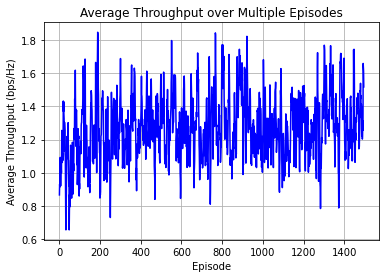

In [70]:
# Function to calculate a simple moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Set the window size for smoothing
window_size = 5

# Calculate the moving average of real rewards
smoothed_rewards = moving_average(avg_reward_all_episodes, window_size)
#smoothed_rewards2 = moving_average(avg_reward_all_episodes2, window_size)
#smoothed_rewards3 = moving_average(avg_reward_all_episodes3, window_size)

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
# ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='blue')
# ax1.semilogy(all_epochs,avg_reward_all_episodes2,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='green')
# ax1.semilogy(all_epochs,avg_reward_all_episodes3,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='red')
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

# Plot the smoothed rewards
#plt.plot(all_epochs[:-window_size+1], smoothed_rewards2, label=f'Smoothed Rewards (Window Size={window_size})', color='red')
#plt.plot(all_epochs[:-window_size+1], smoothed_rewards3, label=f'Smoothed Rewards (Window Size={window_size})', color='green')
plt.plot(all_epochs[:-window_size+1], smoothed_rewards, label=f'Smoothed Rewards (Window Size={window_size})', color='blue')
# ax1.legend(['Round Robin', 'Static', 'Random'])
# Add labels and legend
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('Average Reward vs Episode with Smoothed Rewards')
# plt.legend()

# Show the plot
# plt.show()

save_results_to = 'C:/Users/Zunayeed/Desktop/PhD/WICL/NSF-AoF Project/Simulation BC EH/Debugging/'
#plt.savefig(save_results_to + 'Avg_Throughput_3Strategies_200S_600E_10channels.png', dpi = 300)

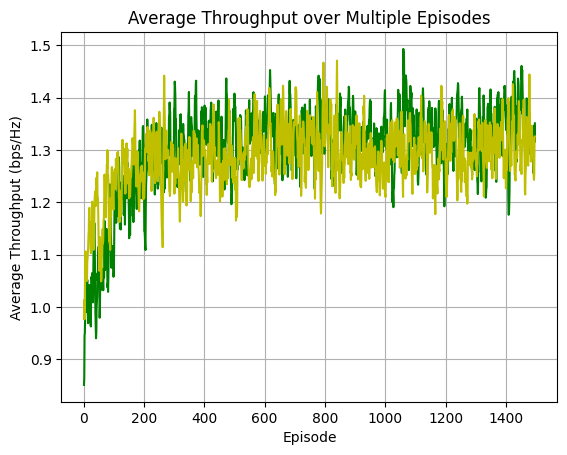

In [ ]:
# Function to calculate a simple moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Set the window size for smoothing
window_size = 5

# Calculate the moving average of real rewards
smoothed_rewards3 = moving_average(avg_reward_all_episodes3, window_size)
smoothed_rewards_ch10 = moving_average(avg_reward_all_episodes_ch10, window_size)

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
# ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='blue')
# ax1.semilogy(all_epochs,avg_reward_all_episodes2,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='green')
# ax1.semilogy(all_epochs,avg_reward_all_episodes3,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='red')
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

# Plot the smoothed rewards
plt.plot(all_epochs[:-window_size+1], smoothed_rewards3, label=f'Smoothed Rewards (Window Size={window_size})', color='green')
plt.plot(all_epochs[:-window_size+1], smoothed_rewards_ch10, label=f'Smoothed Rewards (Window Size={window_size})', color='y')
# ax1.legend(['Round Robin', 'Static', 'Random'])
# Add labels and legend
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('Average Reward vs Episode with Smoothed Rewards')
# plt.legend()

# Show the plot
# plt.show()

save_results_to = 'C:/Users/Zunayeed/Desktop/PhD/WICL/NSF-AoF Project/Simulation BC EH/Debugging/'
#plt.savefig(save_results_to + 'Avg_Throughput_3Strategies_200S_600E_10channels.png', dpi = 300)

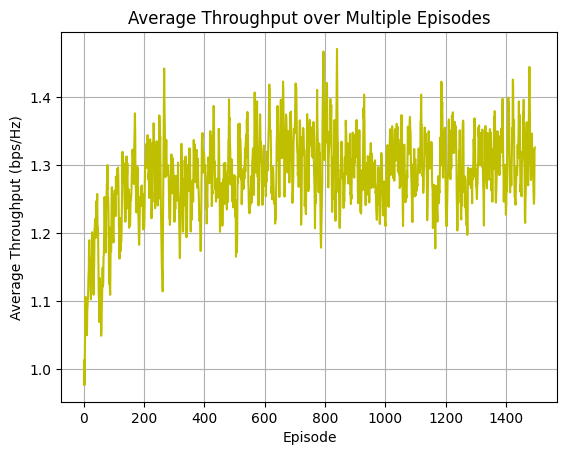

In [ ]:
# Function to calculate a simple moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Set the window size for smoothing
window_size = 5

# Calculate the moving average of real rewards
smoothed_rewards_ch10 = moving_average(avg_reward_all_episodes_ch10, window_size)

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
# ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='blue')
# ax1.semilogy(all_epochs,avg_reward_all_episodes2,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='green')
# ax1.semilogy(all_epochs,avg_reward_all_episodes3,'-*', alpha=0.5, label = 'Learning Rate = 0.1', color ='red')
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Throughput (bps/Hz)')
ax1.set_title('Average Throughput over Multiple Episodes')
plt.grid(True)

# Plot the smoothed rewards
plt.plot(all_epochs[:-window_size+1], smoothed_rewards_ch10, label=f'Smoothed Rewards (Window Size={window_size})', color='y')
# ax1.legend(['Round Robin', 'Static', 'Random'])
# Add labels and legend
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('Average Reward vs Episode with Smoothed Rewards')
# plt.legend()

# Show the plot
# plt.show()

save_results_to = 'C:/Users/Zunayeed/Desktop/PhD/WICL/NSF-AoF Project/Simulation BC EH/Debugging/'
#plt.savefig(save_results_to + 'Avg_Throughput_3Strategies_200S_600E_10channels.png', dpi = 300)

### for debugging ###

In [ ]:
f = 900e6
fJ = 900e6

# **** for path loss ****

# P_J = 20
# Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
# Gt_dBi = 1 #Gain of the Tx antenna in dBi
# Gr_dBi = 1 #Gain of the Rx antenna in dBi
# d0 = 1 #reference distance of receiver from the transmitter in meters
# d = 10 #
# dJ = 2 #distance between Tx and Rx
# L = 1 #Other System Losses, for no Loss case L=1
# sigma=2 #Standard deviation of log Normal distribution (in dB)
# n=2 #
# APBD_path_loss_dB = logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
# jammer_path_loss_dB = logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,fJ,d0,dJ,L,sigma,n)
# print('APBD Path Loss in dB: ',APBD_path_loss_dB)
# print('Jammer Path Loss in dB: ',jammer_path_loss_dB)

# **** for gain ****

H = APBD_ChannelGain(f)
JBD = JBD_ChannelGain(fJ)
JAP = JAP_ChannelGain(fJ)
print('AP - BD Channel Gain: ',H)
#print('AP - BD distance: ',d)
print('Jammer - AP Channel Gain: ',JAP)
print('Jammer - BD Channel Gain: ',JBD)
#print('Jammer - AP/BD Distance: ',dJ)

AP - BD Channel Gain:  9.764508894084387e-05
Jammer - AP Channel Gain:  0.00011315333230151742
Jammer - BD Channel Gain:  0.00013644970515546543


In [ ]:
n = -1
for i in range(20):
    #Jammer Strategy: Static Jammer
    (P_J,f_J,n) = Jammer_Random(n,K_ch)

    k = 0 # AP channel
    f_k = Fc + (k*deltaf)

    P_R = (((abs(ask))**2)*P_T*(APBD_ChannelGain(f_k)**2))
    P_R_AP = sum(P_R)/(N*L) #Average Received Power
    Noise_variance = (P_R_AP)/(10**(20/10)) #Desired SNR assumed to be 20dB
    unwanted_signal = 1*(f_k == f_J)*P_J*JAP_ChannelGain(f_J) + loopback_Channel() + Noise_variance*abs(complex_noise(0, 1, N*L))
    ### 1*(f_k == f_J)*... => 0 if f_K is not equal to f_J
    P_N = sum(unwanted_signal)/(N*L)
    SNR =  P_R_AP/P_N
    SNR_dB = 10*math.log(SNR)
    # #print(SNR)
    throughput = math.log2(1+SNR) #SNR in linear scale will give throughput in bps; Here, throughput (reward) is in bps/Hz
    # print(unwanted_signal)
    # print(y_AP_squared)
    print('AP Channel: ',f_k)
    print('Jammer Channel: ',f_J)
#     print('Received Power: ',P_R_AP)
#     print('Noise Power: ',P_N)
#     print('SNR: ',SNR)
    print('SNR in dB: ',SNR_dB)
#     print('Throughput: ',throughput)


TypeError: Jammer_Random() takes 1 positional argument but 2 were given

In [17]:
action = np.random.randint(0,K_ch,dtype=int)
current_state = action;
# Q-learning algorithm
Action_RR = np.arange(0,K_ch,dtype=int)

In [18]:
print(action)
print('Action_RR',Action_RR)

6
Action_RR [0 1 2 3 4 5 6 7]


In [20]:
k_RR = -1
for i in range(5):
    k_RR = k_RR + 1
    A_RR = np.array([k_RR])
print(A_RR)

[4]


In [21]:
Action_RR = np.concatenate((Action_RR[1:K_ch],A_RR))
print(Action_RR)

[1 2 3 4 5 6 7 4]
